# Calculate and save footprints over entire period.

* ## Intersect with a map of the basin 

* ### Query given footprints and calculate contours

In [61]:
%matplotlib notebook
import sys
import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, shape
import rasterio
from rasterio import features
from rasterio.transform import from_origin
from matplotlib import pyplot as plt
from geopandas import GeoDataFrame
from datetime import datetime
import datetime
from rasterio.plot import show
import Footprint_Processing as FP
import importlib

# Date Range & Paramters
## Read & filter the data, initialize the Basin Map

In [62]:
DateRange=['2016-6-23 12:00:00','2016-8-24 23:30:00']  ## Subset for testing
Axis = 40
rs = [50,75,90]
dx = 1
XY = [516097.33,7707931.12]
nx = 1000 
fp_params={'dx':dx,'nx':nx,'rs':rs}
west = XY[0]-(nx*dx)/2
north = XY[1]+(nx*dx)/2

RasterPath = 'C:/Illisarvik/Footprints/'
DataName = 'FilteredData2018-04-23.csv'

    
Data = pd.read_csv(DataName)
Data = Data.set_index(pd.DatetimeIndex(Data.datetime))
Data['Run']=0
Data.loc[((np.isfinite(Data['Zo'])==True)&np.isfinite(Data['co2_flux'])==True)&(Data['u*']>.1)&
         (Data.index>DateRange[0])&(Data.index<DateRange[1])&              # Run a subset for teting
         ((Data['wind_dir']<Axis+180-30)|(Data['wind_dir']>Axis+180+30)),
         ['Run']]=1
Data=Data.reset_index(drop=True)
Dates = Data['datetime']
Run = Data.loc[Data['Run']==1].reset_index().drop(['index'],axis=1)
Runs = Run.shape[0]

Basin = gpd.read_file('Vegetation1.2.shp')
Basin['Area'] = Basin.area
Basin['Dkey'] = 1
BasinBounds = Basin.dissolve(by='Dkey').geometry[1]  

shapes = ((geom,value) for geom,value in zip(Basin['geometry'],Basin['Code']))
west = XY[0]-(nx*dx)/2
north = XY[1]+(nx*dx)/2
Transform = from_origin(west,north,dx,dx)

with rasterio.open('Basin_Image.tif','w',driver='GTiff',width = nx+1, height = nx+1,count = 1,dtype=np.float64,
                   affine = Transform,crs = ({'init': 'EPSG:32608'})) as out:
    out_arr = out.read(1)
    params = out.profile
    del params['transform']
    Basin_Image = features.rasterize(shapes=shapes,fill = 100,out = out_arr,transform = out.affine,default_value=0)
    out.write(Basin_Image,1)

## Footprints

In [63]:
Run = False
if Run == True:
    importlib.reload(FP)
    FP_Data = FP.Calculate(RasterPath,Run,os.getcwd()+'/Basin_Image.tif',XY,Classes=Basin)
    Data = Data.merge(FP_Data.Intersections,left_on='datetime', right_on='datetime', how='outer')

    Data.to_csv('Data_Footprints_'+str(datetime.datetime.now()).split(' ')[0]+'.csv')


[||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] 100.0%


## Query Footprints

<IPython.core.display.Javascript object>


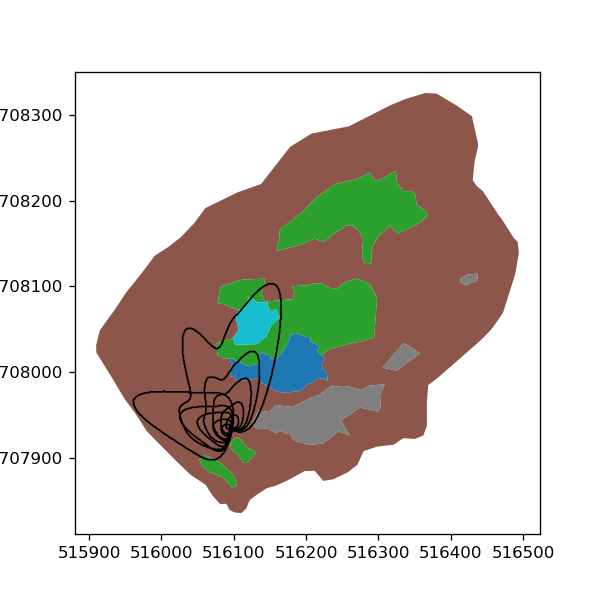

Test1:
[||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] 100.0%
Test2:
[||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] 100.0%


In [57]:

Query=[['2016-7-23 12:30:00','2016-7-24 19:00:00','Test1'],
      ['2016-7-23 12:30:00','2016-7-23 13:30:00','Test2']]
Jobs = {}
for query in Query:
    index = pd.date_range((query[0]),(query[1]),freq='30T')
    Jobs[query[2]]=index
    
fig,ax=plt.subplots(1,1,figsize = (5,5))
Basin.plot(ax=ax,column = 'Name')
Cont = FP.Contours(RasterPath,Jobs=Jobs,ax=ax)